# GPU Info

In [2]:
!nvidia-smi

Mon Feb 24 22:02:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8             N/A /  200W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installations

In [3]:
# !pip3 install torch torchvision torchaudio matplotlib pandas numpy torchmetrics tqdm --break-system-packages

# Imports

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import Adam, SGD, Adamax

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

from PIL import Image

from tqdm import tqdm
from torchmetrics.classification import Dice

import matplotlib.pyplot as plt

from os import listdir, system, getcwd
import re
from datetime import datetime

In [5]:
torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

# Functions and Classes

In [6]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters()])
    
    return f"Number of Parameters: {params:,}"

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = inputs.sum() + targets.sum()

        dice = (2. * intersection + self.smooth) / (total + self.smooth)
        
        return 1 - dice

In [8]:
def dice_loss_fn(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice.mean()

In [9]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def __call__(self, val: float) -> float:
        self.sum += val
        self.counter += 1

        return self.sum / self.counter

    def reset(self):
        self.sum = 0.
        self.counter = 0

In [10]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, avg_fn, ep, device):
    model.train()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate the average of Dice Loss
            avg_loss = avg_fn(loss.item())
            
            trange.set_postfix(Dice_loss=loss.item())

    return model, loss.item()

In [11]:
def validate_one_epoch(model, dataloader, loss_fn, avg_fn, device):
    model.eval()
    avg_fn.reset()

    print("Plase Wait! Validation is being calculated", end='\r')

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward
        yp = model(x_batch)
        loss = loss_fn(yp, y_batch)

        # Calculate the average of Dice Loss
        avg_loss = avg_fn(loss.item())

    print(f"Valid => Dice_loss: {loss.item():.3}".ljust(55))
    
    return loss.item()

In [12]:
def plot_histories(train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(12)
    fig.set_figheight(4)
    fig.suptitle("Learning Curve")

    axs[0].plot(train_loss_hist, c='b', label="Train Loss")
    axs[0].plot(valid_loss_hist, c='r', label="Valid Loss")
    axs[0].set_ylabel("BCE Loss")
    
    axs[1].plot(train_acc_hist, c='b', label="Train Acc")
    axs[1].plot(valid_acc_hist, c='r', label="Valid Acc")
    axs[1].set_ylabel("Accuracy")

    for ax in axs.flatten():
        ax.set_xlabel("Epoch")
        ax.grid()
        ax.legend()

# Device and Inits

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
avg_fn = Averaging()
dice_coef = DiceLoss().to(device)
# dice_coef = Dice().to(device)

# Custom Dataset <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Download Dataset</a>

In [15]:
class MRIDataset(Dataset):
    def __init__(self, transforms, dir_path=f"{getcwd()}/kaggle_3m"):
        self.transforms = transforms
        self.image_pattern = r".tif"
        self.mask_pattern = r"_mask"
        self.images_ls = []
        self.masks_ls = []

        self.to_tensor_transform = T.ToTensor()

        patients_path = listdir(dir_path)
        
        patients_path.remove("data.csv")
        patients_path.remove("README.md")
        # patients_path.remove(".ipynb_checkpoints")

        for patient in patients_path:
            patient_images = listdir(f"{dir_path}/{patient}/")
            patient_images.sort(key=lambda x:x.replace(self.mask_pattern, ""))
            
            for img_path in patient_images:
                if re.search(self.image_pattern, img_path) is None:
                    continue
                
                if re.search(self.mask_pattern, img_path) is None:
                    self.images_ls.append(f"{dir_path}/{patient}/{img_path}")
                else:
                    self.masks_ls.append(f"{dir_path}/{patient}/{img_path}")
            

    def __getitem__(self, item_idx):
        pil_img = Image.open(self.images_ls[item_idx])
        transformed_img = self.transforms(pil_img)
        
        pil_mask = Image.open(self.masks_ls[item_idx])
        transformed_mask = self.to_tensor_transform(pil_mask)

        return transformed_img, transformed_mask
    
    def raw_item(self, item_idx):
        img = Image.open(self.images_ls[item_idx])
        mask = Image.open(self.masks_ls[item_idx])
        label = 1 if torch.max(self.to_tensor_transform(mask)) > 0 else 0
        
        return self.to_tensor_transform(img), self.to_tensor_transform(mask), label

    # TODO: Check the final result for each sample based on the generated mask.
    def check_result(self):
        pass
    
    def __len__(self):
        return len(self.images_ls)

# Preprocessing

## Transforms

In [17]:
img_transforms = T.Compose([
    T.RandomVerticalFlip(),
    T.RandomRotation(60),
    T.AutoAugment(),
    T.ToTensor(),
    T.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

## Read dataset

In [18]:
dataset = MRIDataset(img_transforms, getcwd()+"/brain_mri_dataset/kaggle_3m")

dataset.__len__()

3929

## Visualize Random 6 Samples with Their Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6431372].


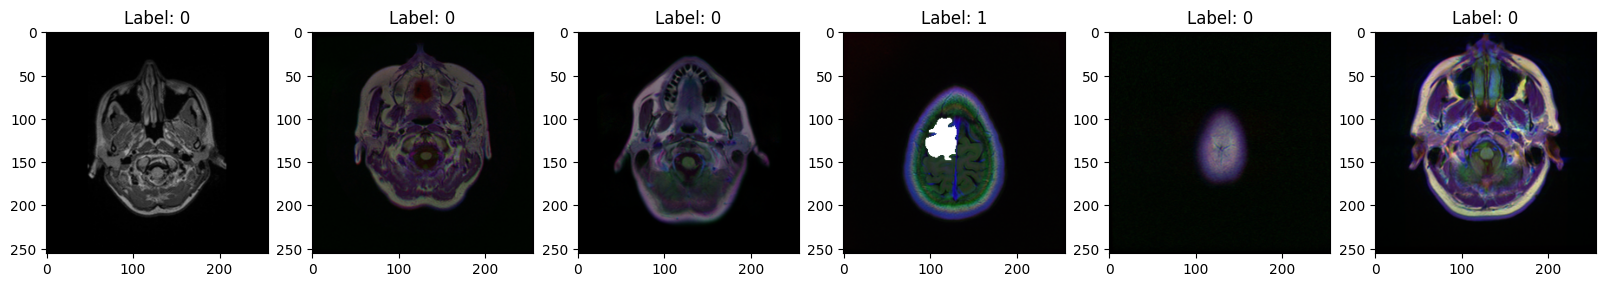

In [19]:
num_images = 6
fig, axs = plt.subplots(nrows=1, ncols=num_images)
fig.set_figwidth(20)

for idx, item_idx in enumerate(torch.randint(dataset.__len__(), (num_images,))):
    img, mask, label = dataset.raw_item(item_idx)
    img_with_mask = img + mask

    axs[idx].set_title(f"Label: {label}")
    axs[idx].imshow(img_with_mask.permute(1, 2, 0))

## Split Train, Valid, Test sets

In [20]:
train_set, valid_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

len(train_set.indices), len(valid_set.indices), len(test_set.indices)

(2751, 786, 392)

## Make Dataloader

In [21]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=32)

In [22]:
img, label = next(iter(train_loader))

img.shape, label.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256]))

# U-Net Model

In [20]:
class UNetModel(nn.Module):
    def __init__(self, unet_size="medium", input_channel=3, num_cls=1):
        super().__init__()

        assert unet_size in ["small", "medium", "large"]
        
        i, j = 0, 0

        if unet_size == "small":
            conv_channels = [input_channel] + [16, 32, 64, 128, 256]
        elif unet_size == "medium":
            conv_channels = [input_channel] + [32, 64, 128, 256, 512]
        else:
            conv_channels = [input_channel] + [64, 128, 256, 512, 1024]
        
        conv_channels_len = len(conv_channels)
        self.conv_ls = nn.ModuleDict()
        self.concat_idx = []
        
        # Encoder
        for channel_idx in range(1, conv_channels_len):
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx])
            self.conv_ls[f"save_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx])

            # The Stride of the MaxPool must be equal 2 to exactly halve the height and width of the image
            if channel_idx != conv_channels_len-1:
                self.conv_ls[f"max_pool_{i}"] = nn.MaxPool2d(2, 2, 1, return_indices=True)
    
            i += 1
            j += 1

        i = 0
        
        # Decoder
        for channel_idx in range(conv_channels_len-1, 1, -1):
            self.conv_ls[f"up_conv_{i}"] = self.up_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])
            self.conv_ls[f"max_unpool_{i}"] = nn.MaxUnpool2d(3, 2, 1)
            
            self.conv_ls[f"concat_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])

            # The last layer (Classifier layer)
            if channel_idx == 2:
                self.conv_ls[f"conv_{j}"] = nn.Conv2d(conv_channels[channel_idx-1], num_cls, kernel_size=1)
                continue
            
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx-1])
            i += 1
            j += 1
            
    def __repr__(self):
        print(self.conv_ls)
        
        return "U-Net()"
    
    def normal_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def up_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, y: torch.Tensor):
        concatenation_ls, max_pool_indeces = [], []

        for layer_name in self.conv_ls.keys():
            layer = self.conv_ls[layer_name]
            
            if re.search(r"max_pool_*", layer_name):
                y, indeces = layer(y)
                max_pool_indeces.append(indeces)

            elif re.search(r"max_unpool_*", layer_name):
                concat = concatenation_ls.pop()
                concatenation_ls.append(concat)
                y = layer(y, max_pool_indeces.pop(), output_size=concat.shape)

            elif re.search(r"save_conv_[0-3]$", layer_name):
                y = layer(y)
                concatenation_ls.append(y)
                
            elif re.search(r"concat_conv_*", layer_name):
                concat = concatenation_ls.pop()
                y = torch.concat((concat, y), dim=1)
                y = layer(y)

            else:
                y = layer(y)

        return torch.sigmoid(y)

In [37]:
model = UNetModel()
num_parameters(model)

'Number of Parameters: 8,628,033'

# Check Paths

## Forward

In [21]:
with torch.no_grad():
    model = UNetModel().to(device)

    x_batch, y_batch = next(iter(train_loader))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    yp = model(x_batch)
    loss = dice_loss(yp, y_batch)

torch.cuda.empty_cache()

loss.item()

0.9954511523246765

## Backward

In [41]:
mini_percentage = 0.2

_, mini_dataset = random_split(dataset, [1-mini_percentage, mini_percentage])
mini_dataloader = DataLoader(mini_dataset, batch_size=16, shuffle=True)

In [42]:
model = UNetModel("small").to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

for ep in range(4):
    model, _ = train_one_epoch(model, mini_dataloader, optimizer, dice_coef, avg_fn, ep, device)
    validate_one_epoch(model, mini_dataloader, dice_coef, avg_fn, device)
    
torch.cuda.empty_cache()

Epoch 0:   0%|                                                                                               | 0/50 [00:00<?, ? batch/s]


ValueError: The `target` has to be an integer tensor.

# Find Efficient Hyper-Parameters

In [22]:
start_time = datetime.now().replace(microsecond=0)

for lr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    model = UNetModel("small").to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print(f"\nlr: {lr}")
    for ep in range(3):
        model, _ = train_one_epoch(model, train_loader, optimizer, dice_loss, avg_fn, ep, device)
        validate_one_epoch(model, valid_loader, dice_loss, avg_fn, device)
        
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")


lr: 1e-05


Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.966]


Valid => Dice_loss: 0.996                              


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.972]


Valid => Dice_loss: 0.995                              


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.936]


Valid => Dice_loss: 0.995                              

lr: 0.0001


Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.34 batch/s, Dice_loss=0.977]


Valid => Dice_loss: 0.995                              


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.966]


Valid => Dice_loss: 0.994                              


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.956]


Valid => Dice_loss: 0.993                              

lr: 0.001


Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.979]


Valid => Dice_loss: 0.993                              


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.987]


Valid => Dice_loss: 0.988                              


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.916]


Valid => Dice_loss: 0.978                              

lr: 0.01


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=1]


Valid => Dice_loss: 1.0                                


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=1]


Valid => Dice_loss: 0.926                              


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=1]


Valid => Dice_loss: 1.0                                

lr: 0.1


Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.883]


Valid => Dice_loss: 1.0                                


Epoch 1: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.998]


Valid => Dice_loss: 0.986                              


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 172/172 [02:07<00:00,  1.35 batch/s, Dice_loss=0.741]


Valid => Dice_loss: 1.0                                

Run Time: 0:35:17


# Full Train

In [21]:
model = UNetModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-04)

best_valid_loss = torch.inf
final_model = None

num_parameters(model)

'Number of Parameters: 8,628,033'

In [22]:
train_loss_hist, valid_loss_hist = [], []

In [ ]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(30):
    model, train_loss = train_one_epoch(model, train_loader, optimizer, dice_loss, avg_fn, ep, device)
    valid_loss = validate_one_epoch(model, valid_loader, dice_loss, avg_fn, device)

    if best_valid_loss > valid_loss:
        final_model = model

    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

# Learning Curve

In [ ]:
plot_histories(train_loss_hist, [], valid_loss_hist, []);

# Save the Trained Model

In [ ]:
torch.save(final_model, "./final_model.pt")

# Testing Phase

In [27]:
# final_model_loaded = torch.load("./final_model.pt", weights_only=False).to(device)
final_model_loaded = model
num_parameters(final_model_loaded)

'Number of Parameters: 2,159,777'

In [28]:
start_time = datetime.now().replace(microsecond=0)

with torch.inference_mode():
    test_loss = validate_one_epoch(final_model_loaded, test_loader, dice_loss, avg_fn, device)
    
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

Valid => Dice_loss: 0.677                              

Run Time: 0:00:07


In [29]:
test_iter = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].


Text(0.5, 1.0, 'yp + mask')

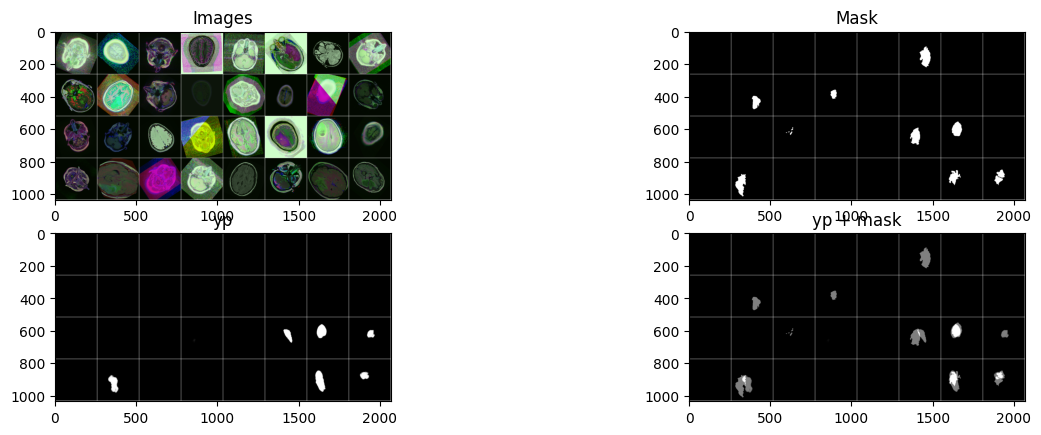

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)

with torch.inference_mode():
    img, mask = next(test_iter)
    img = img.to(device)
    
    yp = final_model_loaded(img)

    torch.cuda.empty_cache()

yp = yp.to("cpu")
img = img.to("cpu")

grid_img = make_grid(img, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mask = make_grid(mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_yp = make_grid(yp, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mix = make_grid(yp+mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)

axs[0][0].imshow(grid_img)
axs[0][0].set_title("Images")

axs[0][1].imshow(grid_mask)
axs[0][1].set_title("Mask")

axs[1][0].imshow(grid_yp)
axs[1][0].set_title("yp")

axs[1][1].imshow(grid_mix)
axs[1][1].set_title("yp + mask")